<a href="https://colab.research.google.com/github/stefanziog/Quantized-Deep-Neural-Networks/blob/main/int8/fashion_mnist_int8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pylab as plt
from keras.datasets import cifar10
import pathlib
import matplotlib.pylab as plt

assert float(tf.__version__[:3]) >= 2.3

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# load train and test dataset
def load_dataset():
# load dataset
  data = keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images, test_labels) = data.load_data()
	
  return train_images, train_labels, test_images, test_labels

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]


In [ ]:
## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

In [ ]:
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [ ]:
# load dataset
train_images, train_labels, test_images, test_labels = load_dataset()

# prepare pixel data
train_images, test_images = prep_pixels(train_images, test_images)

#load model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Διπλωματική Κώδικες τελικοί/saved_models/fashion_mnist.h5')

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmps0d2xxqu/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp6wk_n24b/assets


INFO:tensorflow:Assets written to: /tmp/tmp6wk_n24b/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpl9tq38ho/assets


INFO:tensorflow:Assets written to: /tmp/tmpl9tq38ho/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpjfm2w97h/assets


INFO:tensorflow:Assets written to: /tmp/tmpjfm2w97h/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/fashion_mnist_int8_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"fashion_mnist_int8_model.tflite"
tflite_model_file.write_bytes(tflite_model)

1747756

In [ ]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"fashion_mnist_int8_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

455608

In [ ]:
# Change this to test a different image
test_image_index = 1


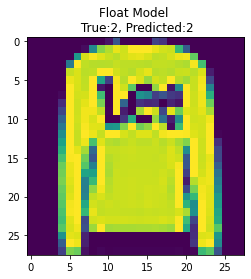

In [ ]:
test_model(tflite_model_quant_file, test_image_index, model_type="Float")

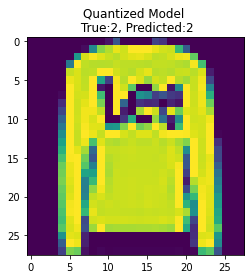

In [ ]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [ ]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 93.2600% (Number of test samples=10000)


In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 93.1800% (Number of test samples=10000)


In [ ]:
ls -lh {tflite_models_dir}

total 2.2M
-rw-r--r-- 1 root root 445K Sep 10 13:25 fashion_mnist_int8_model_quant.tflite
-rw-r--r-- 1 root root 1.7M Sep 10 13:25 fashion_mnist_int8_model.tflite
